# Questions
1. What tables and features differentiate blood-transfusion-related and non-blood-transfusion-related admittances?
2. How many hospital admittances in MIMIC-III are for blood transfusions?
3. Break down these stats by race, by gender, by other demographics
4. How common is it for a blood transfusion to be cut short?
5. What's the average/most extreme body temp difference between the start of transfusion end of transfusion? After 2 hrs? After 4? 8? 24?
6. Characterise the clinicians notes for admittances that were for blood transfusions.

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from google.cloud import bigquery
pd.set_option('display.max_rows', 100)    # Show all rows



load_dotenv()
query_path = os.environ.get('BASE_QUERY_PATH')
client = bigquery.Client(os.environ.get('BIGQUERY_PROJECT_NAME'))

In [2]:
with open(f"{query_path}/scratch.sql", 'r') as file:
    query = file.read()

results = client.query(query).to_dataframe()
results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,f0_
0,20


## Question 1: What tables and features differentiate blood-transfusion-related and non-blood-transfusion-related admittances?


Potentially relevant tables:
* INPUTEVENTS_CV, INPUTEVENTS_MV, OUTPUTEVENTS: https://mimic.mit.edu/docs/iii/about/io/ 
* chartevents, datetimeevents, procedureevents_mv, services

NB: Timeshifting - https://mimic.mit.edu/docs/iii/about/time/#date-shifting
* Time of day, Day of week, and season(winter, spring, summer, fall) preserved
* year, exact day of month, patient overlap in ICU not preserved

NB: MIMIC Schema - https://mit-lcp.github.io/mimic-schema-spy/index.html 


In [3]:
# get the types of items that can be administered to a patient
with open(f"{query_path}/types_of_items_cv.sql", 'r') as file:
    query_cv = file.read()
with open(f"{query_path}/types_of_items_mv.sql", 'r') as file:
    query_mv = file.read()

results_cv = client.query(query_cv).to_dataframe()
print(results_cv)
results_mv = client.query(query_mv).to_dataframe()
results_mv

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   itemid                label category dbsource  count
0   30179               PRBC's     None  carevue      1
1   30005  Fresh Frozen Plasma     None  carevue      1
2   30180    Fresh Froz Plasma     None  carevue      1
3   30001         Packed RBC's     None  carevue      1
4   30004        Washed PRBC's     None  carevue      1


/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,itemid,label,category,dbsource,count
0,227378,Patient Location,ADT,metavision,1
1,226543,Religion,ADT,metavision,1
2,226544,Language,ADT,metavision,1
3,226545,Race,ADT,metavision,1
4,226228,Gender,ADT,metavision,1
...,...,...,...,...,...
2987,220283,Resistance,Respiratory,metavision,1
2988,228382,Total Peripheral Resistance Index (TPRI) (NICOM),NICOM,metavision,1
2989,228183,SVRI (PiCCO)_OLD_1,PiCCO,metavision,1
2990,228185,SVRI (PiCCO),PiCCO,metavision,1


In [4]:
#found category 'Blood Products/Colloids', ONLY IN MV
with open(f"{query_path}/all_blood_products.sql", 'r') as file:
    query = file.read()

results = client.query(query).to_dataframe()
results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,label,itemid,category,dbsource,count
0,Packed Red Blood Cells,225168,Blood Products/Colloids,metavision,1
1,Platelets,225170,Blood Products/Colloids,metavision,1
2,Cryoprecipitate,225171,Blood Products/Colloids,metavision,1
3,Cell Saver,225173,Blood Products/Colloids,metavision,1
4,Hetastarch (Hespan) 6%,225174,Blood Products/Colloids,metavision,1
5,PACU Packed RBC Intake,227070,Blood Products/Colloids,metavision,1
6,PACU Platelet Intake,227071,Blood Products/Colloids,metavision,1
7,PACU FFP Intake,227072,Blood Products/Colloids,metavision,1
8,Fresh Frozen Plasma,220970,Blood Products/Colloids,metavision,1
9,IV Immune Globulin (IVIG),227530,Blood Products/Colloids,metavision,1


In [61]:
# as per our esteemed clinician's advice, we will use the following blood products:
chosen_blood_products_mv = (225168, 225170, 225171, 227070, 227071, 227072, 220970, 227532, 226367, 226368, 226369, 226371)
chosen_blood_products_cv = (30179, 30001, 30004, 30005, 30180)
# https://mimic.mit.edu/docs/iii/tables/inputevents_mv/ 

with open(f"{query_path}/all_blood_inputs.sql", 'r') as file:
    query = file.read()

all_results = client.query(query).to_dataframe()
all_results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,subject_id,hadm_id,icustay_id,starttime,endtime,duration_minutes,itemid,rate,rateuom,label,amount,amountuom,totalamount,totalamountuom,statusdescription,cancelreason,orderid,linkorderid
0,41689,198882,267012,2156-06-06 08:15:00,2156-06-06 08:16:00,1,226367,NaN,None,OR FFP Intake,2073.0,ml,2073.0,ml,FinishedRunning,0,3249863,3249863
1,43893,165157,279552,2134-12-12 03:46:00,2134-12-12 03:47:00,1,226367,NaN,None,OR FFP Intake,1129.0,ml,1129.0,ml,FinishedRunning,0,4376090,4376090
2,57572,141317,284176,2153-03-13 23:26:00,2153-03-13 23:27:00,1,226367,NaN,None,OR FFP Intake,550.0,ml,550.0,ml,FinishedRunning,0,8767781,8767781
3,90868,142945,214608,2100-12-03 18:55:00,2100-12-03 18:56:00,1,226367,NaN,None,OR FFP Intake,2009.0,ml,2009.0,ml,FinishedRunning,0,1488969,1488969
4,97421,175510,277868,2189-03-13 18:00:00,2189-03-13 18:01:00,1,226367,NaN,None,OR FFP Intake,2581.0,ml,2581.0,ml,FinishedRunning,0,1985537,1985537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42653,76476,160007,272401,2187-03-05 08:15:00,2187-03-05 10:35:00,140,225168,150.0,mL/hour,Packed Red Blood Cells,350.0,ml,350.0,ml,Rewritten,2,3514692,3514692
42654,85397,132664,203973,2175-02-22 13:26:00,2175-02-22 15:18:00,112,225168,150.0,mL/hour,Packed Red Blood Cells,280.0,ml,280.0,ml,Rewritten,2,2096265,2096265
42655,65002,127453,271284,2136-02-12 09:25:00,2136-02-12 11:45:00,140,225168,150.0,mL/hour,Packed Red Blood Cells,350.0,ml,350.0,ml,Rewritten,2,1674703,1674703
42656,71921,135295,274159,2177-09-29 17:10:00,2177-09-29 19:10:00,120,225168,150.0,mL/hour,Packed Red Blood Cells,300.0,ml,375.0,ml,Rewritten,2,7484166,7484166


amountuom
ml    42658
Name: count, dtype: int64

totalamountuom
ml    42658
Name: count, dtype: int64

statusdescription
FinishedRunning    36371
Rewritten           5613
Changed              358
Stopped              287
Paused                27
Flushed                2
Name: count, dtype: int64

cancelreason
0    37097
1     2982
2     2579
Name: count, dtype: Int64

rate
350.000010     4214
NaN            4074
375.000000     1835
150.000000     1477
175.000002     1258
               ... 
996.000000        1
1038.461520       1
175.362498        1
100.689654        1
253.012044        1
Name: count, Length: 3251, dtype: int64

Empty DataFrame
Columns: [subject_id, hadm_id, icustay_id, starttime, endtime, duration_minutes, itemid, rate, rateuom, label, amount, amountuom, totalamount, totalamountuom, statusdescription, cancelreason, orderid, linkorderid]
Index: []

min amount -4290.0 max amount 315276.9928
min duration -27 max duration 36000
1836 amounts < 0mL
21060 amounts > 1000mL
84

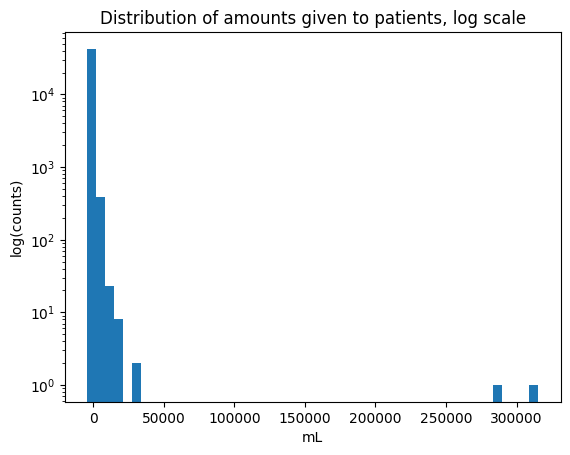

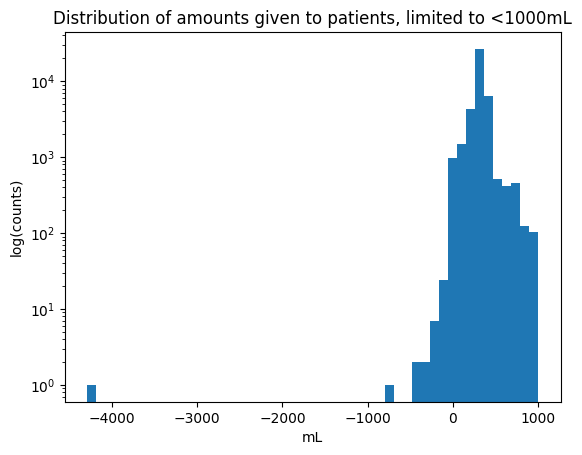

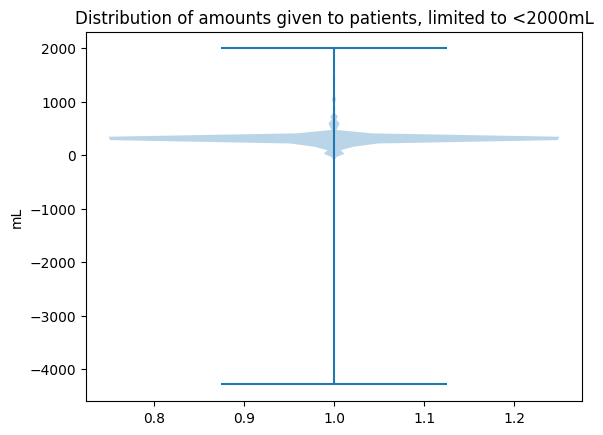

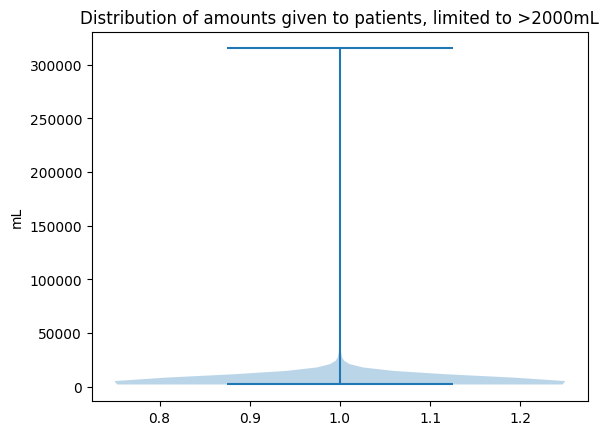

,subject_id,hadm_id,icustay_id,starttime,endtime,duration_minutes,itemid,rate,rateuom,label,amount,amountuom,totalamount,totalamountuom,statusdescription,cancelreason,orderid,linkorderid
8080,47613,193577,252601,2123-09-23 18:21:00,2123-09-23 19:21:00,60,220970,287295.996,mL/hour,Fresh Frozen Plasma,287295.9960,ml,287296.0,ml,Rewritten,2,3310191,3310191
41697,96309,183337,279533,2120-09-26 09:10:00,2120-09-26 10:06:00,56,220970,337796.778,mL/hour,Fresh Frozen Plasma,315276.9928,ml,315.0,ml,Rewritten,1,5221728,5221728


In [65]:
import matplotlib.pyplot as plt
import numpy as np
"""
sanity check: 
amountuoms are all the same
totalamountuoms are all the same
rates are reasonable
counts of status descriptions
types of cancelreasons
amounts are greater than 0
durations are reasonable
where does totalamount not match amount?
"""
print(all_results.amountuom.value_counts(dropna=False))
print()
print(all_results.totalamountuom.value_counts(dropna=False))
print()
print(all_results.statusdescription.value_counts(dropna=False))
print()
print(all_results.cancelreason.value_counts(dropna=False))
print()
print(all_results.rate.value_counts(dropna=False))
print()


#what entry has ul?
uLentries = all_results[all_results.amountuom == 'uL']
print(uLentries)
print()

print("min amount", min(all_results.amount), 'max amount', max(all_results.amount))
print("min duration", min(all_results.duration_minutes), 'max duration', max(all_results.duration_minutes))

#amounts are not greater than 0 generally speaking!
print(f"{np.size(all_results[all_results.amount < 0])} amounts < 0mL")
print(f"{np.size(all_results[all_results.amount > 1000])} amounts > 1000mL")
print(f"{np.size(all_results[all_results.amount > 2000])} amounts > 2000mL")
print(f"{np.size(all_results[all_results.amount > 10000])} amounts > 10000mL")
print(f"{np.size(all_results[all_results.amount > 20000])} amounts > 20000mL")
print(f"{np.size(all_results[all_results.amount > 50000])} amounts > 50000mL")

# plt.hist(all_results.amount, bins=[0, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, max(all_results.amount)])
# plt.hist(all_results.amount, bins=[0, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, max(all_results.amount)], density=True)
plt.hist(all_results.amount, bins=50, log=True)
plt.title("Distribution of amounts given to patients, log scale")
plt.ylabel("log(counts)")
plt.xlabel("mL")
plt.show()

plt.hist(all_results[all_results.amount < 1000].amount, bins=50, log=True)
plt.title("Distribution of amounts given to patients, limited to <1000mL")
plt.ylabel("log(counts)")
plt.xlabel("mL")
plt.show()

plt.violinplot(all_results[all_results.amount < 2000].amount)
plt.title("Distribution of amounts given to patients, limited to <2000mL")
plt.ylabel("mL")
plt.show()
plt.violinplot(all_results[all_results.amount > 2000].amount)
plt.title("Distribution of amounts given to patients, limited to >2000mL")
plt.ylabel("mL")
plt.show()

all_results[all_results.amount > 50000]

([<matplotlib.patches.Wedge at 0x7df1b4508980>,
 [Text(-0.9841820909607933, 0.49131009742528275, 'FinishedRunning'),
  Text(0.9585926398744918, -0.539536978138156, 'Rewritten'),
  Text(1.097077633175366, -0.0801290633062511, 'Changed'),
  Text(1.099644968268648, -0.027945371019978293, 'Stopped'),
  Text(1.0999971335495091, -0.0025112114334140444, 'Paused'),
  Text(1.0999999880878955, -0.00016188461937287446, 'Flushed')])

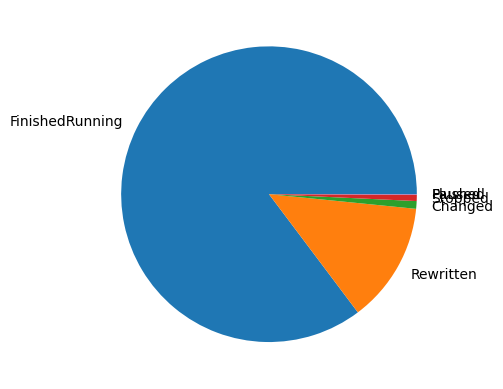

In [23]:
plt.pie(all_results.statusdescription.value_counts(), labels=all_results.statusdescription.value_counts().index)

In [7]:
rounded_amounts = np.round(all_results.amount, decimals=2)
rounded_amounts.value_counts().reset_index()[:15]

,amount,count
0,350.0,10486
1,375.0,6091
2,280.0,1305
3,278.0,829
4,279.0,811
5,281.0,758
6,282.0,681
7,275.0,668
8,300.0,628
9,277.0,610


1632 durations < 0 min
1664 durations > 500 min
464 durations > 5000 min
duration_minutes
60     0.398518
1      0.110812
30     0.065451
120    0.040883
15     0.025857
112    0.014347
180    0.013972
168    0.013784
150    0.013643
140    0.012471
105    0.010549
21     0.009189
20     0.008111
42     0.007173
225    0.007033
Name: proportion, dtype: Float64


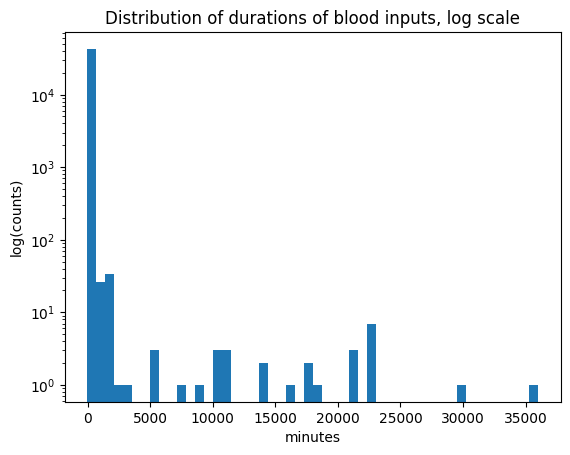

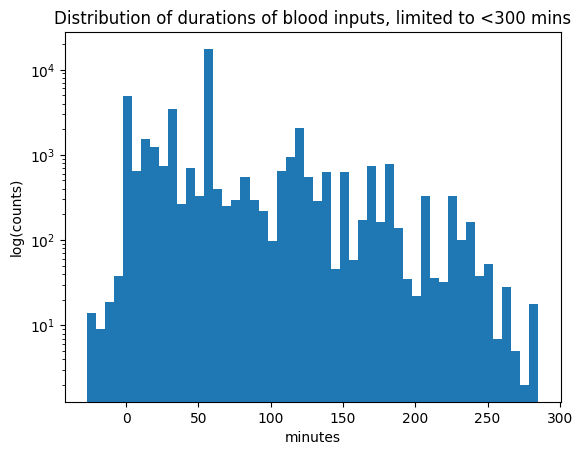

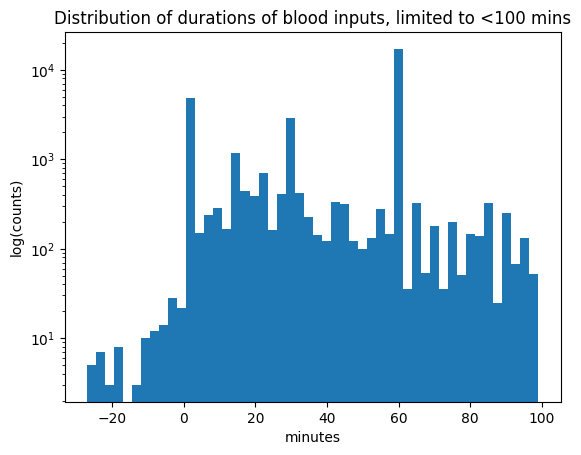

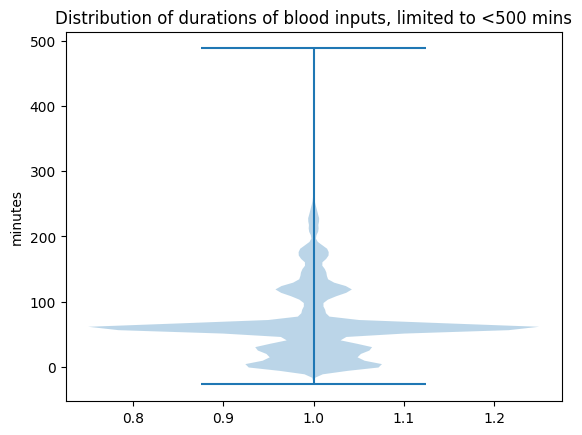

In [25]:
print(f"{np.size(all_results[all_results.duration_minutes < 0])} durations < 0 min")
print(f"{np.size(all_results[all_results.duration_minutes > 500])} durations > 500 min")
print(f"{np.size(all_results[all_results.duration_minutes > 5000])} durations > 5000 min")

print(all_results.duration_minutes.value_counts(normalize=True)[:15])


plt.hist(all_results.duration_minutes, bins=50, log=True)
plt.title("Distribution of durations of blood inputs, log scale")
plt.ylabel("log(counts)")
plt.xlabel("minutes")
plt.show()

plt.hist(all_results[all_results.duration_minutes < 300].duration_minutes, bins=50, log=True)
plt.title("Distribution of durations of blood inputs, limited to <300 mins")
plt.ylabel("log(counts)")
plt.xlabel("minutes")
plt.show()

plt.hist(all_results[all_results.duration_minutes < 100].duration_minutes, bins=50, log=True)
plt.title("Distribution of durations of blood inputs, limited to <100 mins")
plt.ylabel("log(counts)")
plt.xlabel("minutes")
plt.show()

plt.violinplot(all_results[all_results.duration_minutes < 500].duration_minutes)
plt.title("Distribution of durations of blood inputs, limited to <500 mins")
plt.ylabel("minutes")
plt.show()
# plt.violinplot(all_results[all_results.amount > 2000].amount)
# plt.title("Distribution of amounts given to patients, limited to >2000mL")
# plt.ylabel("mL")
# plt.show()

/tmp/ipykernel_1771/419103254.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(all_results.duration_minutes, all_results.amount, c=(0.1, 0.2, 0.5, 0.05))


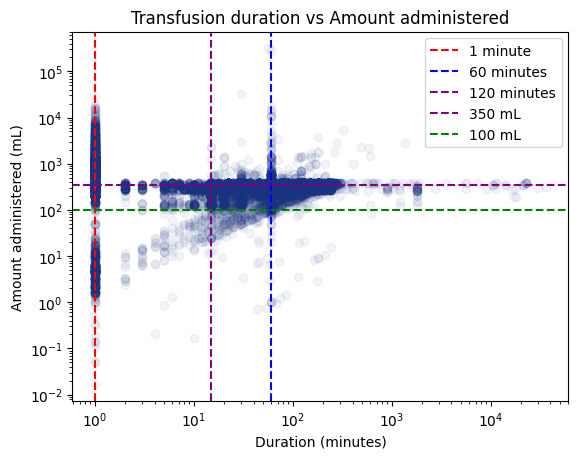

In [60]:
# are durations properly correlated with amounts?
fig = plt.figure()
ax = plt.gca()
ax.scatter(all_results.duration_minutes, all_results.amount, c=(0.1, 0.2, 0.5, 0.05))
plt.axvline(x=1, color='red', linestyle='--', label='1 minute')
# plt.axvline(x=30, color='green', linestyle='--', label='30 minutes')
plt.axvline(x=60, color='blue', linestyle='--', label='60 minutes')
plt.axvline(x=15, color='purple', linestyle='--', label='120 minutes')
plt.axhline(y=350, color='purple', linestyle='--', label='350 mL')
plt.axhline(y=100, color='green', linestyle='--', label='100 mL')
ax.set_title('Transfusion duration vs Amount administered')
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Amount administered (mL)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
plt.show()

Text(0, 0.5, 'Y-axis')

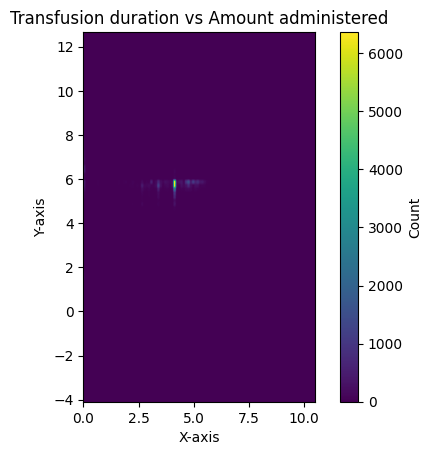

In [46]:
# another view of the above scatterplot;
no_neg = all_results[(all_results.duration_minutes>0) & (all_results.amount>0)]
log_mins = np.log(no_neg.duration_minutes)
log_amounts = np.log(no_neg.amount)
hist, xedges, yedges = np.histogram2d(log_mins, log_amounts, bins=100)
plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
plt.colorbar(label='Count')
plt.title('Transfusion duration vs Amount administered')
plt.xlabel('duration (log(minutes)')
plt.ylabel('Y-axis')


In [10]:
# based on https://github.com/MIT-LCP/mimic-code/issues/14, negative amounts might be associated with cancelled orders
with open(f"{query_path}/completed_blood_inputs.sql", 'r') as file:
    completed_query = file.read()

completed_results = client.query(completed_query).to_dataframe()
completed_results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,subject_id,hadm_id,icustay_id,starttime,endtime,duration_minutes,itemid,label,amount,amountuom,totalamount,totalamountuom,statusdescription,cancelreason,orderid,linkorderid
0,49925,108652,289319,2152-06-22 05:00:00,2152-06-22 05:01:00,1,227072,PACU FFP Intake,305.000000,ml,305.0,ml,FinishedRunning,0,3261436,3261436
1,44717,198296,219081,2136-05-27 11:45:00,2136-05-27 11:46:00,1,226367,OR FFP Intake,582.000000,ml,582.0,ml,FinishedRunning,0,1593803,1593803
2,41107,130510,226924,2108-04-24 00:54:00,2108-04-24 00:55:00,1,226367,OR FFP Intake,590.000000,ml,590.0,ml,FinishedRunning,0,4480597,4480597
3,70485,162746,287313,2196-11-10 22:15:00,2196-11-10 22:16:00,1,226367,OR FFP Intake,297.000000,ml,297.0,ml,FinishedRunning,0,2595549,2595549
4,48123,111089,207812,2173-10-31 23:00:00,2173-10-31 23:01:00,1,226367,OR FFP Intake,3942.000000,ml,3942.0,ml,FinishedRunning,0,2665475,2665475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37092,77842,170389,243033,2110-09-01 12:20:00,2110-09-01 13:20:00,60,225168,Packed Red Blood Cells,283.000002,ml,283.0,ml,FinishedRunning,0,1968238,1968238
37093,42781,101975,250693,2198-03-20 07:50:00,2198-03-20 08:50:00,60,225168,Packed Red Blood Cells,283.000002,ml,283.0,ml,FinishedRunning,0,4212316,4212316
37094,90122,149949,204536,2104-02-26 03:51:00,2104-02-26 04:51:00,60,225168,Packed Red Blood Cells,283.000002,ml,283.0,ml,FinishedRunning,0,1896473,1896473
37095,84116,139239,207141,2167-08-19 22:05:00,2167-08-19 23:05:00,60,225168,Packed Red Blood Cells,283.000002,ml,283.0,ml,FinishedRunning,0,9843593,9843593


amountuom
ml    37097
Name: count, dtype: int64

totalamountuom
ml    37097
Name: count, dtype: int64

statusdescription
FinishedRunning    36371
Changed              358
Stopped              287
Rewritten             52
Paused                27
Flushed                2
Name: count, dtype: int64

cancelreason
0    37097
Name: count, dtype: Int64

Empty DataFrame
Columns: [subject_id, hadm_id, icustay_id, starttime, endtime, duration_minutes, itemid, label, amount, amountuom, totalamount, totalamountuom, statusdescription, cancelreason, orderid, linkorderid]
Index: []

min amount 0.0 max amount 28700.0
min duration 1 max duration 3562
0 amounts < 0mL
17520 amounts > 1000mL
6912 amounts > 2000mL
352 amounts > 10000mL
16 amounts > 20000mL
0 amounts > 50000mL


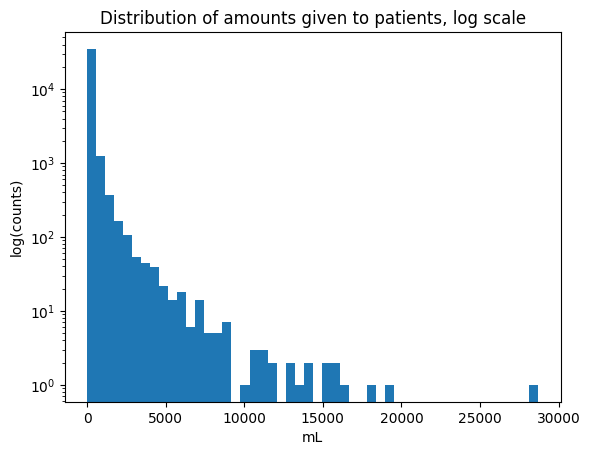

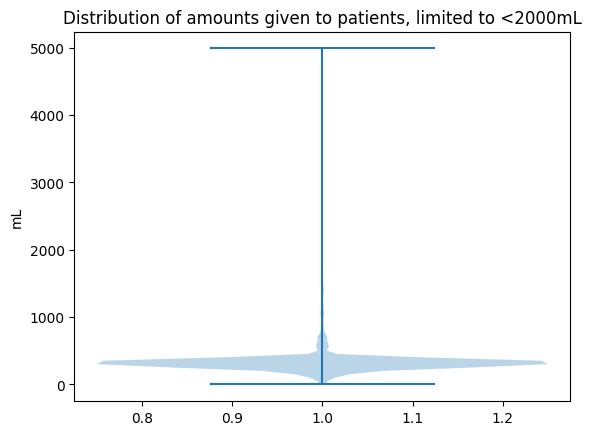

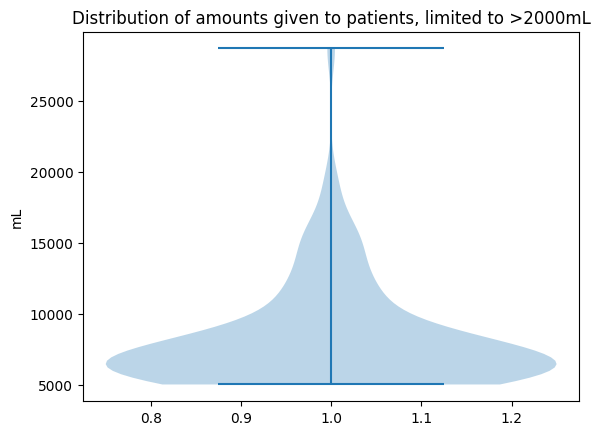

,subject_id,hadm_id,icustay_id,starttime,endtime,duration_minutes,itemid,label,amount,amountuom,totalamount,totalamountuom,statusdescription,cancelreason,orderid,linkorderid


In [41]:
print(completed_results.amountuom.value_counts())
print()
print(completed_results.totalamountuom.value_counts())
print()
print(completed_results.statusdescription.value_counts())
print()
print(completed_results.cancelreason.value_counts())
print()

#what entry has ul?
uLentries = completed_results[completed_results.amountuom == 'uL']
print(uLentries)
print()

print("min amount", min(completed_results.amount), 'max amount', max(completed_results.amount))
print("min duration", min(completed_results.duration_minutes), 'max duration', max(completed_results.duration_minutes))

print(f"{np.size(completed_results[completed_results.amount < 0])} amounts < 0mL")
print(f"{np.size(completed_results[completed_results.amount > 1000])} amounts > 1000mL")
print(f"{np.size(completed_results[completed_results.amount > 2000])} amounts > 2000mL")
print(f"{np.size(completed_results[completed_results.amount > 10000])} amounts > 10000mL")
print(f"{np.size(completed_results[completed_results.amount > 20000])} amounts > 20000mL")
print(f"{np.size(completed_results[completed_results.amount > 50000])} amounts > 50000mL")
# plt.hist(completed_results.amount, bins=[0, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, max(completed_results.amount)])
# plt.hist(completed_results.amount, bins=[0, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, max(completed_results.amount)], density=True)
plt.hist(completed_results.amount, bins=50, log=True)
plt.title("Distribution of amounts given to patients, log scale")
plt.ylabel('log(counts)')
plt.xlabel("mL")
plt.show()
plt.violinplot(completed_results[completed_results.amount < 5000].amount)
plt.title("Distribution of amounts given to patients, limited to <2000mL")
plt.ylabel("mL")
plt.show()
plt.violinplot(completed_results[completed_results.amount > 5000].amount)
plt.title("Distribution of amounts given to patients, limited to >2000mL")
plt.ylabel("mL")
plt.show()

completed_results[completed_results.amount > 50000]

In [12]:
completed_rounded_amounts = np.round(completed_results.amount, decimals=2)
completed_rounded_amounts.value_counts().reset_index()[:15]

,amount,count
0,350.0,9447
1,375.0,4998
2,280.0,1159
3,279.0,738
4,278.0,733
5,281.0,683
6,282.0,620
7,275.0,595
8,277.0,553
9,300.0,539


0 durations < 0 min
384 durations > 500 min
0 durations > 5000 min
duration_minutes
60     0.411192
1      0.104887
30     0.067014
120    0.042348
15     0.025716
168     0.01399
112    0.013856
180    0.013775
150    0.013182
140     0.01275
105    0.010783
21     0.008761
20     0.008195
42      0.00744
210    0.006685
Name: proportion, dtype: Float64


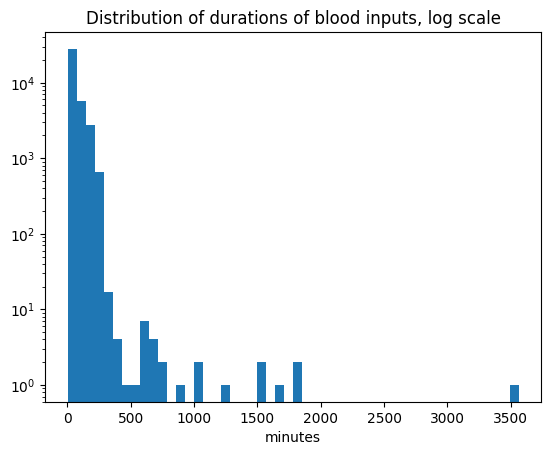

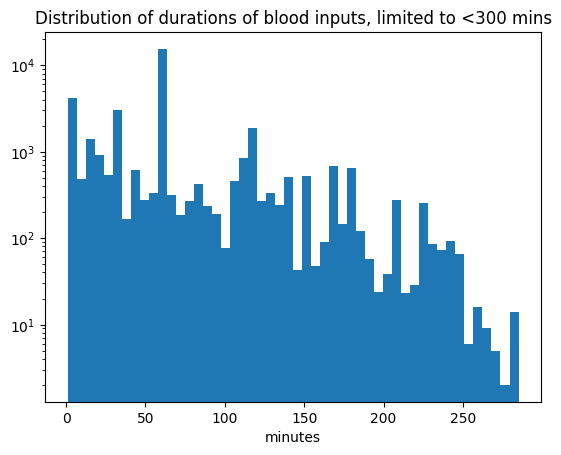

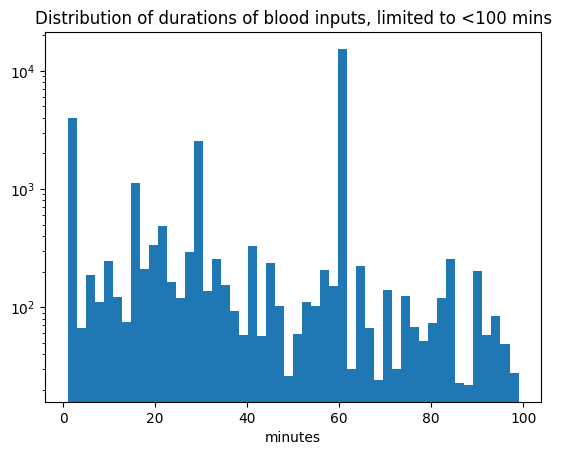

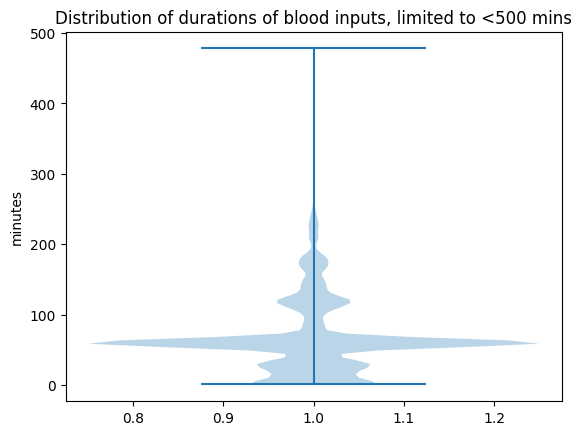

In [13]:
print(f"{np.size(completed_results[completed_results.duration_minutes < 0])} durations < 0 min")
print(f"{np.size(completed_results[completed_results.duration_minutes > 500])} durations > 500 min")
print(f"{np.size(completed_results[completed_results.duration_minutes > 5000])} durations > 5000 min")

print(completed_results.duration_minutes.value_counts(normalize=True)[:15])

plt.hist(completed_results.duration_minutes, bins=50, log=True)
plt.title("Distribution of durations of blood inputs, log scale")
plt.xlabel("minutes")
plt.show()

plt.hist(completed_results[completed_results.duration_minutes < 300].duration_minutes, bins=50, log=True)
plt.title("Distribution of durations of blood inputs, limited to <300 mins")
plt.xlabel("minutes")
plt.show()

plt.hist(completed_results[completed_results.duration_minutes < 100].duration_minutes, bins=50, log=True)
plt.title("Distribution of durations of blood inputs, limited to <100 mins")
plt.xlabel("minutes")
plt.show()

plt.violinplot(completed_results[completed_results.duration_minutes < 500].duration_minutes)
plt.title("Distribution of durations of blood inputs, limited to <500 mins")
plt.ylabel("minutes")
plt.show()

/tmp/ipykernel_1771/2589843231.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(completed_results.duration_minutes, completed_results.amount, c=(0.1, 0.2, 0.5, 0.05))


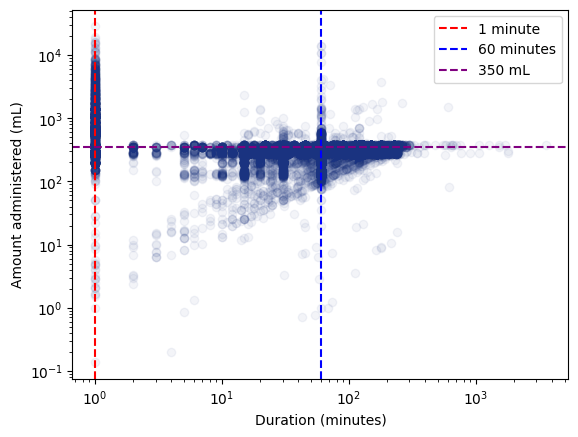

In [50]:
# are durations properly correlated with amounts?
fig = plt.figure()
ax = plt.gca()
ax.scatter(completed_results.duration_minutes, completed_results.amount, c=(0.1, 0.2, 0.5, 0.05))
plt.axvline(x=1, color='red', linestyle='--', label='1 minute')
# plt.axvline(x=30, color='green', linestyle='--', label='30 minutes')
plt.axvline(x=60, color='blue', linestyle='--', label='60 minutes')
# plt.axvline(x=120, color='purple', linestyle='--', label='120 minutes')
plt.axhline(y=350, color='purple', linestyle='--', label='350 mL')
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Amount administered (mL)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
plt.show()

In [15]:
with open(f"{query_path}/blood_input_amounts_by_item.sql", 'r') as file:
    amounts_by_item_query = file.read()

amounts_by_item_results = client.query(amounts_by_item_query).to_dataframe()
amounts_by_item_results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,itemid,label,count,avg_ml,min_ml,max_ml
0,226367,OR FFP Intake,998,1269.651303,0.000000,19509.000000
1,226368,OR Packed RBC Intake,2002,1147.009990,0.000000,28700.000000
2,226369,OR Platelet Intake,781,480.852753,-4290.000000,4627.000000
3,226371,OR Cryoprecipitate Intake,196,367.964286,0.000000,7000.000000
4,227072,PACU FFP Intake,14,461.142857,237.000000,1064.000000
5,227070,PACU Packed RBC Intake,75,557.000000,0.000000,2625.000000
6,227071,PACU Platelet Intake,8,390.875000,192.000000,600.000000
7,220970,Fresh Frozen Plasma,8428,363.023850,-325.000020,315276.992800
8,225168,Packed Red Blood Cells,24836,328.344719,-735.000000,14250.000000
9,225170,Platelets,4160,246.186608,-116.666662,3010.000200


In [16]:
with open(f"{query_path}/completed_blood_input_amounts_by_item.sql", 'r') as file:
    completed_amounts_by_item_query = file.read()

completed_amounts_by_item_results = client.query(completed_amounts_by_item_query).to_dataframe()
completed_amounts_by_item_results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,itemid,label,count,avg_ml,min_ml,max_ml
0,220970,Fresh Frozen Plasma,7163,292.153726,0.136187,13800.000000
1,225168,Packed Red Blood Cells,21358,331.893417,0.200000,14250.000000
2,225170,Platelets,3770,247.730963,2.871000,1441.999980
3,225171,Cryoprecipitate,899,141.294223,4.096000,330.000012
4,226367,OR FFP Intake,947,1295.394931,0.000000,19509.000000
5,226368,OR Packed RBC Intake,1884,1162.985138,0.000000,28700.000000
6,226369,OR Platelet Intake,741,492.190283,0.000000,4627.000000
7,226371,OR Cryoprecipitate Intake,191,369.340314,92.000000,7000.000000
8,227070,PACU Packed RBC Intake,71,573.422535,250.000000,2625.000000
9,227071,PACU Platelet Intake,6,388.666667,192.000000,594.000000


In [17]:
# # curiosity, use the rbc_transfusion.sql file from github ==> doesn't work :/
# with open(f"{query_path}/rbc_transfusion.sql", 'r') as file:
#     rbc_transfusion_query = file.read()

# rbc_transfusion_results = client.query(rbc_transfusion_query).to_dataframe()
# rbc_transfusion_results